# In this notebook, we will be creating a sample diversified(very) portfolio based on securities' Sharpe ratios. We will look at the monthly returns of stocks over the past year. We will then make an update to this notebook in 1 month to see how the portfolio did

## The Sharpe ratio is calculated by first subtracting a risk-free investment from the mean returns(in this case, monthly), and then dividing by the standard deviation of those returns
$$
General Formula = 
S = \frac{R_p - R_f}{\sigma_p}
$$

$$
Annualizing Monthly Sharpe Ratio = 
S_{annual} = S_{monthly} \times \sqrt{12}
$$


## This project's free return will be based on the US Treasury Bill Returns
## As of Sunday September 7, 2025, the 1-Month U.S. Treasury Bill yield—expressed as an annualized rate—is approximately 4.33%.

$$
R_{f, \text{monthly}} \approx 0.3608\%
$$


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pickle
from tqdm import tqdm
import os
import pandas_datareader.data as web
import time
from datetime import datetime
import warnings
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import sys
import networkx as nx
from selenium import webdriver
from selenium.webdriver.common.by import By
from stockdex import Ticker


import requests
from bs4 import BeautifulSoup as bs
import pprint
warnings.filterwarnings("ignore")

In [2]:
# Get Sp500 tickers
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
}

response = requests.get(url, headers=headers)
tables = pd.read_html(response.text)

sp500_tickers_df = tables[0]
sp500_tickers_df["Symbol"] = sp500_tickers_df["Symbol"].str.replace(".", "-")
tickers = sp500_tickers_df.Symbol.tolist()

In [3]:
# Read in all stock data
stock_data = pd.DataFrame()

start = time.time()
print("Loading...")
# Columns returned by .yahoo_api_price: timestamp	volume	close	open	high	low	currency	timezone	exchangeTimezoneName	exchangeName	instrumentType 
for ticker in tickers: 
    temp_tick = Ticker(ticker)
    security_df = temp_tick.yahoo_api_price(range='1y', dataGranularity='1d')
    security_df = security_df[["timestamp", "low", "high", "open", "close", "instrumentType"]]
    security_df["Symbol"] = ticker
    
    stock_data = pd.concat([stock_data, security_df])
end = time.time()

print(f"Finished: {end - start}")

Loading...
Finished: 124.65312719345093


In [70]:
# Copy df to not have to rerun above loop
sp500_prices_df = stock_data.copy()
#

In [5]:
# Scrape large index funds using selium and eventually add to the df
url_categories = ["index-etfs", "sector-etfs", "commodity-etfs", "country-etfs"]
etfs = pd.DataFrame()

for url in url_categories:
    data = []
    driver = webdriver.Chrome()  
    driver.get(f"https://www.cnbc.com/{url}/")
    time.sleep(5)  
    
    # Locate the table
    table = driver.find_element(By.CLASS_NAME, "BasicTable-tableBody") # Class of table
    
    # Extract rows
    rows = table.find_elements(By.TAG_NAME, "tr")
    

    for row in rows:
        cols = [col.text for col in row.find_elements(By.TAG_NAME, "td")]
        if cols:
            data.append(cols)
    
    df = pd.DataFrame(data)
    #df = df[df.columns[:2]]
    #df.columns = ["Ticker", "Name"]
    df["Type"] = url
    display(df.head())
    print()


    etfs = pd.concat([etfs, df])
    
    
    driver.quit()

,0,1,2,3,4,5,6,7,8,Type
0,SPY,SPDR S&P 500 ETF Trust,648.19,+0.95,+0.15,"29,622,315",647.75,649.84,647.24,index-etfs
1,QQQ,Invesco QQQ Trust,578.71,+2.65,+0.46,"28,188,493",578.07,580.84,576.06,index-etfs
2,IWM,iShares Russell 2000 ETF,237.5,-0.27,-0.11,"16,572,131",236.39,238.56,237.77,index-etfs
3,DIA,SPDR Dow Jones Industrial Average ETF Trust,454.71,-0.28,-0.06,"2,741,344",453.63,456,454.99,index-etfs
4,VTI,Vanguard Total Stock Market Index Fund ETF Shares,320.11,+0.56,+0.18,"2,475,013",319.77,320.92,319.55,index-etfs


,0,1,2,3,4,5,6,7,8,Type
0,XLE,Energy Select Sector SPDR Fund,86.93,-0.43,-0.49,"11,052,133",86.39,88.03,87.36,sector-etfs
1,XLF,Financial Select SPDR Fund,53.04,-0.03,-0.06,"21,085,202",52.84,53.12,53.07,sector-etfs
2,XLU,Utilities Select Sector SPDR Fund,82.64,-0.83,-1,"8,171,804",82.46,83.56,83.47,sector-etfs
3,XLI,Industrial Select Sector SPDR Fund,151.07,+0.13,+0.09,"7,009,417",150.11,151.54,150.93,sector-etfs
4,GDX,VanEck Gold Miners ETF,67.12,+0.78,+1.18,"14,701,425",66.49,67.41,66.34,sector-etfs


,0,1,2,3,4,5,6,7,8,Type
0,GLD,SPDR Gold Shares,334.51,+3.46,+1.05,"11,182,762",333.23,335.67,331.05,commodity-etfs
1,SLV,iShares Silver Trust,37.44,+0.23,+0.62,"16,047,207",37.36,37.83,37.21,commodity-etfs
2,UNG,United States Natural Gas Fund,13.13,+0.19,+1.47,"5,605,778",13.09,13.46,12.94,commodity-etfs
3,USO,"United States Oil Fund, LP",72.95,+0.32,+0.44,"2,574,011",72.57,73.54,72.63,commodity-etfs
4,IAU,iShares Gold Trust,68.5,+0.73,+1.08,"3,906,395",68.23,68.75,67.76,commodity-etfs


,0,1,2,3,4,5,6,7,8,Type
0,EWJ,iShares MSCI Japan ETF,80.8,+1.61,+2.04,"3,894,503",80.39,80.95,79.18,country-etfs
1,FXI,iShares China Large-Cap ETF,39.28,+0.38,+0.97,"16,896,275",39.13,39.35,38.9,country-etfs
2,EWZ,iShares MSCI Brazil ETF,29.4,-0.23,-0.79,"11,895,396",29.27,29.66,29.63,country-etfs
3,EWT,iShares MSCI Taiwan ETF,60.74,+0.52,+0.87,"1,428,489",60.6,60.84,60.21,country-etfs
4,DXJ,WisdomTree Japan Hedged Equity Fund,129.86,+2.65,+2.08,"388,498",129.02,129.95,127.21,country-etfs


In [71]:
# Save important info
#etfs = etfs[etfs.columns[:2]]
etfs_temp = etfs.rename(columns={etfs.columns[0]: "Ticker", etfs.columns[1]: "Name"})
#etfs_temp["Type"] = etfs["Type"]

etfs = etfs_temp.copy() # Copy over the df
etfs.head()

,Ticker,Name,2,3,4,5,6,7,8,Type
0,SPY,SPDR S&P 500 ETF Trust,648.19,+0.95,+0.15,"29,622,315",647.75,649.84,647.24,index-etfs
1,QQQ,Invesco QQQ Trust,578.71,+2.65,+0.46,"28,188,493",578.07,580.84,576.06,index-etfs
2,IWM,iShares Russell 2000 ETF,237.5,-0.27,-0.11,"16,572,131",236.39,238.56,237.77,index-etfs
3,DIA,SPDR Dow Jones Industrial Average ETF Trust,454.71,-0.28,-0.06,"2,741,344",453.63,456,454.99,index-etfs
4,VTI,Vanguard Total Stock Market Index Fund ETF Shares,320.11,+0.56,+0.18,"2,475,013",319.77,320.92,319.55,index-etfs


In [7]:
# Get all etf data
etf_temp = pd.DataFrame()
etfs_symbols = etfs.Ticker.tolist()

# Same thing from above
start = time.time()
print("Loading...")
for e in etfs_symbols:
    temp_tick = Ticker(e)
    temp_df = temp_tick.yahoo_api_price(range='1y', dataGranularity='1d')
    temp_df = temp_df[["timestamp", "low", "high", "open", "close", "instrumentType"]]
    temp_df["Symbol"] = e

    etf_temp = pd.concat([etf_temp, temp_df])
end = time.time()

print(f"Finished: {end-start}")

Loading...
Finished: 19.50689721107483


In [106]:
#copy over
etf_prices = etf_temp.copy()
# etf_prices = etf_prices.query('Symbol not in ["SGOL"]')

In [107]:
print("------------------------------------------- SP500 DATA -------------------------------------------")
display(sp500_prices_df.head(10))
print(); print()

print("-------------------------------------------- ETF Data --------------------------------------------")
display(etf_prices.head(10))

------------------------------------------- SP500 DATA -------------------------------------------


,timestamp,low,high,open,close,instrumentType,Symbol
0,2024-09-09 13:30:00,128.190002,130.979996,129.389999,128.460007,EQUITY,MMM
1,2024-09-10 13:30:00,128.460007,130.160004,128.850006,130.089996,EQUITY,MMM
2,2024-09-11 13:30:00,127.120003,130.380005,129.500000,130.229996,EQUITY,MMM
3,2024-09-12 13:30:00,130.100006,132.720001,130.300003,132.029999,EQUITY,MMM
4,2024-09-13 13:30:00,131.350006,133.369995,131.880005,133.179993,EQUITY,MMM
5,2024-09-16 13:30:00,133.830002,135.279999,133.979996,134.610001,EQUITY,MMM
6,2024-09-17 13:30:00,132.309998,134.429993,134.089996,133.570007,EQUITY,MMM
7,2024-09-18 13:30:00,131.759995,134.279999,133.259995,133.360001,EQUITY,MMM
8,2024-09-19 13:30:00,133.320007,135.320007,134.399994,133.839996,EQUITY,MMM
9,2024-09-20 13:30:00,132.770004,134.949997,133.009995,134.770004,EQUITY,MMM




-------------------------------------------- ETF Data --------------------------------------------


,timestamp,low,high,open,close,instrumentType,Symbol
0,2024-09-09 13:30:00,542.679993,547.710022,544.650024,546.409973,ETF,SPY
1,2024-09-10 13:30:00,543.380005,549.150024,548.359985,548.789978,ETF,SPY
2,2024-09-11 13:30:00,539.960022,555.359985,548.700012,554.419983,ETF,SPY
3,2024-09-12 13:30:00,552.739990,559.400024,555.010010,559.090027,ETF,SPY
4,2024-09-13 13:30:00,559.450012,563.030029,559.710022,562.010010,ETF,SPY
5,2024-09-16 13:30:00,559.900024,563.109985,561.739990,562.840027,ETF,SPY
6,2024-09-17 13:30:00,560.789978,566.580017,565.099976,563.070007,ETF,SPY
7,2024-09-18 13:30:00,560.830017,568.690002,563.739990,561.400024,ETF,SPY
8,2024-09-19 13:30:00,568.080017,572.880005,571.010010,570.979980,ETF,SPY
9,2024-09-20 13:30:00,565.169983,569.309998,567.840027,568.250000,ETF,SPY


In [108]:
# Concatonate both dfs
all_security_data = pd.concat([sp500_prices_df, etf_prices])
all_security_data = all_security_data.set_index("timestamp")

In [109]:
# Get monthly_pct_change
all_security_data['(t+1)'] = all_security_data.groupby('Symbol')['close'].shift(-21) 
all_security_data["Monthly_Pct_Change"] = (all_security_data['(t+1)'] - all_security_data['close']) / all_security_data['close']
all_security_data = all_security_data.drop(columns = "(t+1)")

all_security_data = all_security_data.drop(pd.Timestamp("2025-09-08 17:03:19"), errors='ignore')
all_security_data

,low,high,open,close,instrumentType,Symbol,Monthly_Pct_Change
timestamp,,,,,,,
2024-09-09 13:30:00,128.190002,130.979996,129.389999,128.460007,EQUITY,MMM,0.048498
2024-09-10 13:30:00,128.460007,130.160004,128.850006,130.089996,EQUITY,MMM,0.037820
2024-09-11 13:30:00,127.120003,130.380005,129.500000,130.229996,EQUITY,MMM,0.024802
2024-09-12 13:30:00,130.100006,132.720001,130.300003,132.029999,EQUITY,MMM,0.020601
2024-09-13 13:30:00,131.350006,133.369995,131.880005,133.179993,EQUITY,MMM,0.019372
...,...,...,...,...,...,...,...
2025-08-29 13:30:00,56.930000,57.700001,56.930000,57.669998,ETF,EZA,NaN
2025-09-02 13:30:00,56.549999,57.320000,56.680000,57.250000,ETF,EZA,NaN
2025-09-03 13:30:00,57.439999,57.939999,57.689999,57.700001,ETF,EZA,NaN


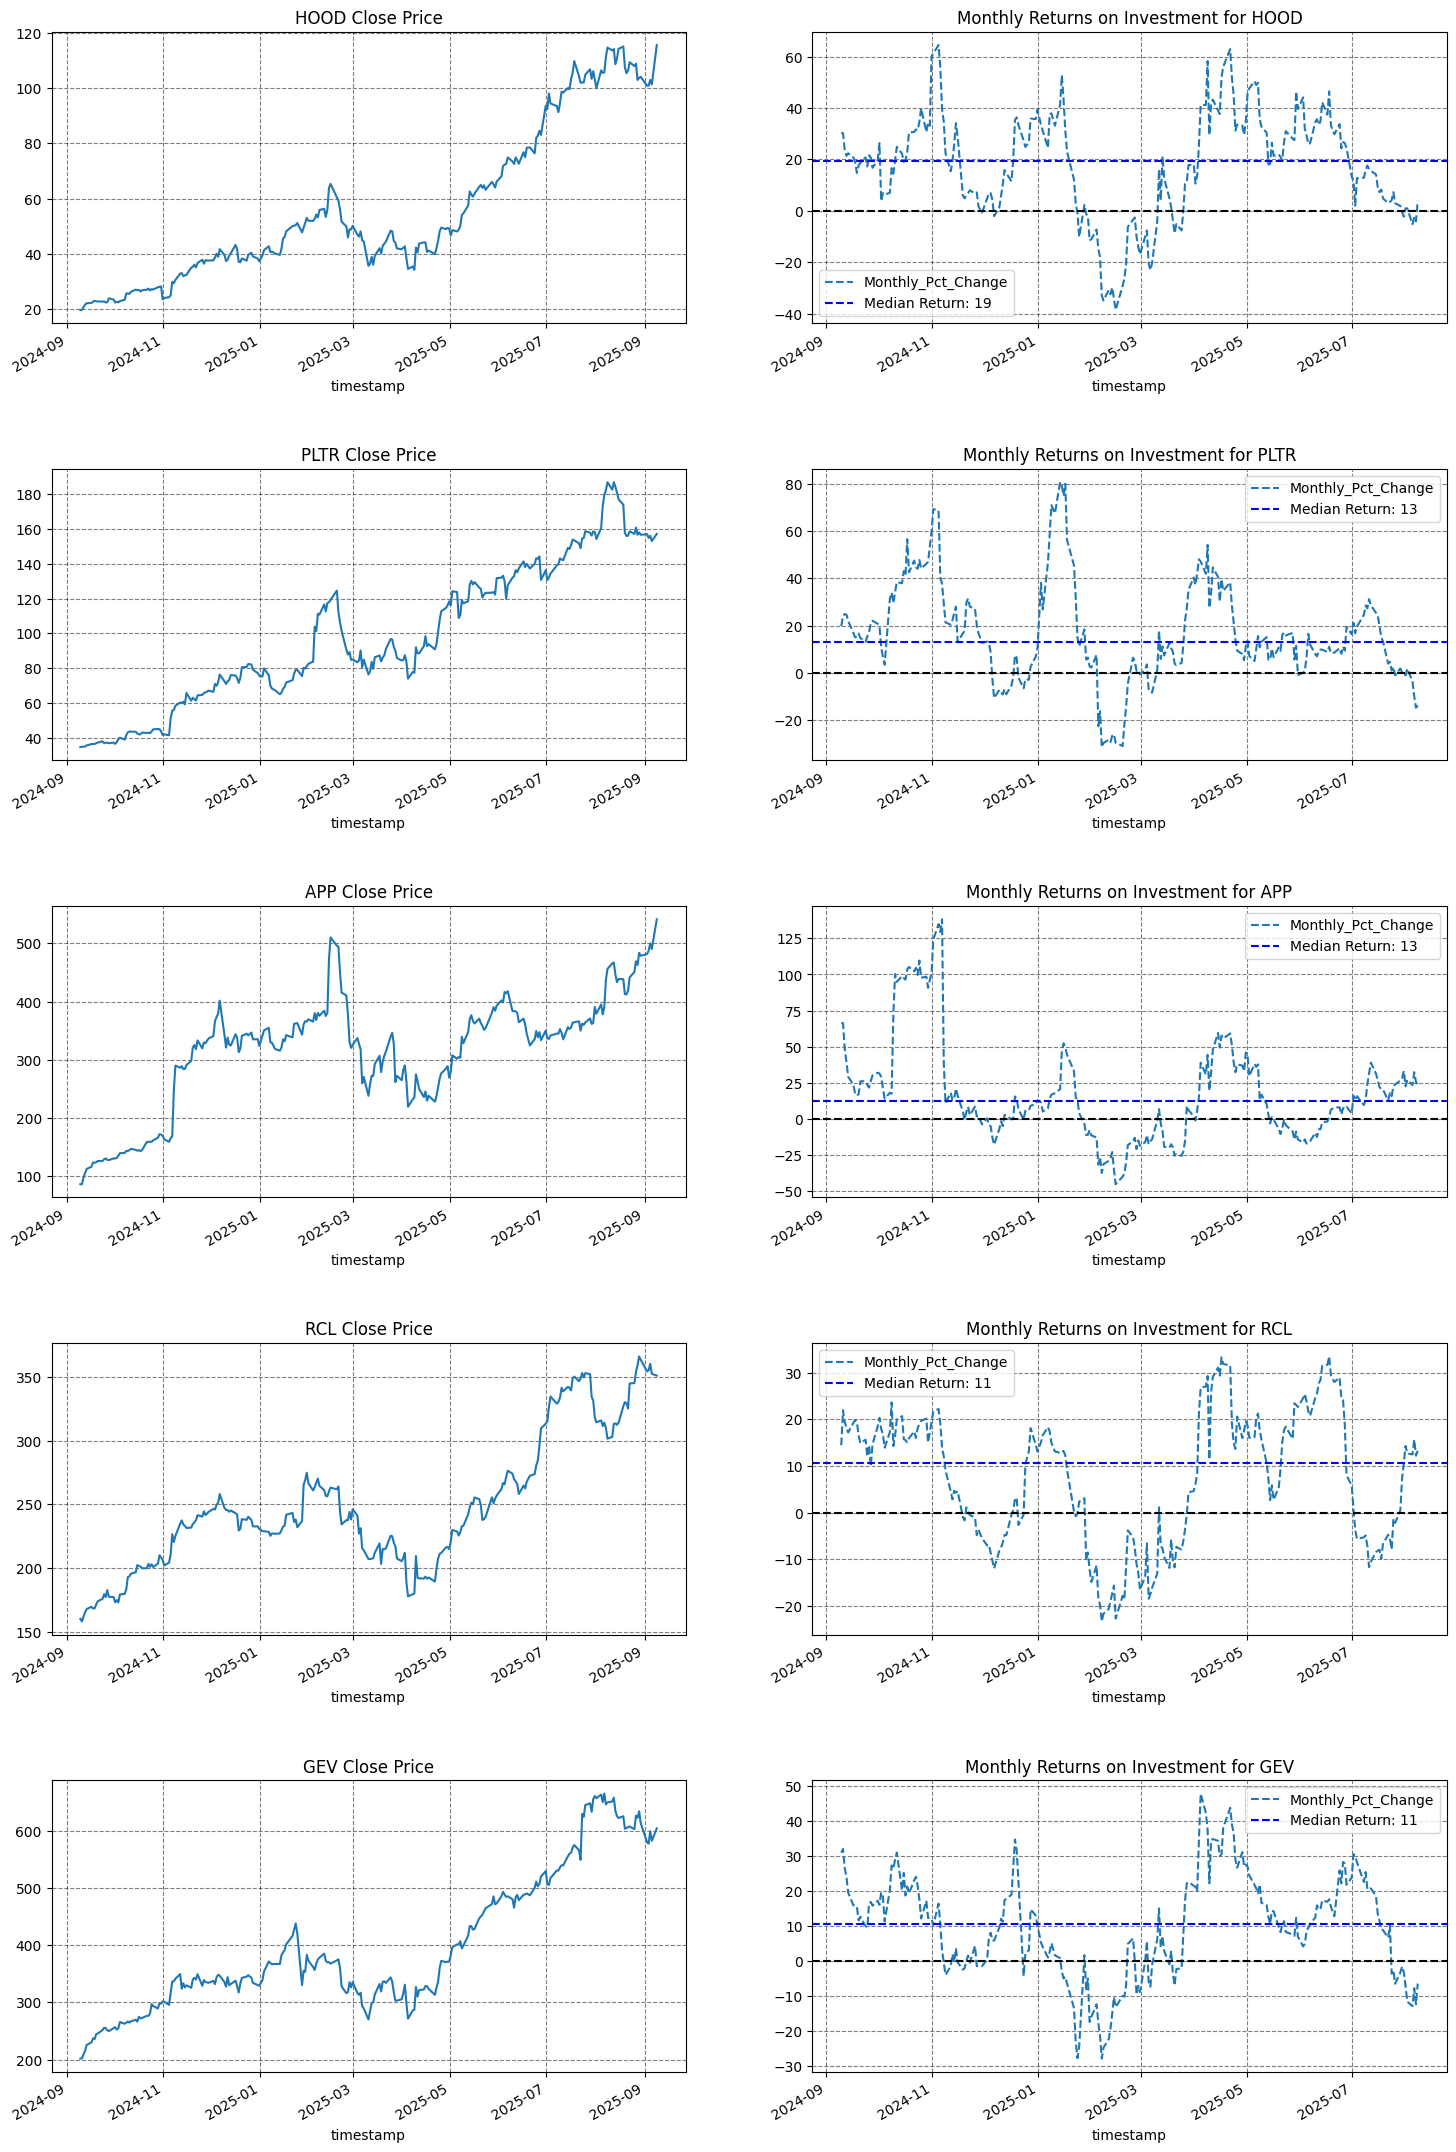

In [110]:
# Plot well performing stocks
top_performers = all_security_data.groupby('Symbol', as_index = False)["Monthly_Pct_Change"].median()
top_performers = top_performers.sort_values(by = "Monthly_Pct_Change", ascending = False).head(5)

# Plot best performing stocks(based off of 1 month return) over the past 6 months
fig, ax = plt.subplots(5, 2, figsize = (18, 30))
#fig.suptitle("Best Performing Stocks Based on 1-Month Returns")
for i, symb in enumerate(top_performers.Symbol):
    
    temp = all_security_data.query('Symbol == @symb')
    temp["Monthly_Pct_Change"] = temp["Monthly_Pct_Change"] * 100
    temp.close.plot(ax = ax[i, 0]); ax[i, 0].set_title(f"{symb} Close Price")
    temp.Monthly_Pct_Change.plot(ax=ax[i, 1], linestyle = '--'); ax[i, 1].axhline(y = 0, color = 'k', linestyle = '--') 

    lab = f"Median Return: {round(float(top_performers.query('Symbol == @symb')['Monthly_Pct_Change']) * 100)}"
    ax[i, 1].axhline(y=float(top_performers.query('Symbol == @symb')['Monthly_Pct_Change'])*100, color='blue', linestyle='--', label=lab)
    ax[i, 1].legend()

    
    ax[i, 1].set_title(f"Monthly Returns on Investment for {symb}")
    
    ax[i,0].grid(linestyle = '--', alpha = 0.5, color = 'k'); ax[i,1].grid(linestyle = '--', alpha = 0.5, color = 'k')

plt.subplots_adjust(hspace = 0.5)

## Here, we will group stocks into buckets/graphs to diversify our portfolio. Each group theoretically will represent a sector or branch of the economy. We will do this grouping by seeing which stocks have the most similar monthly returns in terms of correlation.
## Our goal is to invest in the best security in each cluster if the Sharpe ratio is above 0.5(annualized), however, if addidtional stocks are performing exceptionally well, we will add them into our pool of investments.

### We will use the networx library to make easy groupings based off of correlations of stock returns from month-to-month

In [111]:
# Widen df to calculate correlations between monthly returns of stocks
stock_data_wide = all_security_data.dropna().pivot_table(
    index="timestamp",
    columns="Symbol",
    values="Monthly_Pct_Change"
)
stock_corr = stock_data_wide.corr().rename_axis(index="Ticker2", columns="Ticker1")

display(stock_corr)

Ticker1,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ACWI,ADBE,ADI,...,XOM,XOP,XRT,XTL,XYL,XYZ,YUM,ZBH,ZBRA,ZTS
Ticker2,,,,,,,,,,,,,,,,,,,,,
A,1.000000,0.378180,0.132887,0.366252,0.217513,0.212146,0.561688,0.690593,0.379640,0.552053,...,0.257823,0.685510,0.699792,0.687029,0.502375,0.491228,-0.129577,0.165905,0.713884,0.575592
AAPL,0.378180,1.000000,0.355352,0.432552,0.071100,-0.115480,0.299547,0.519891,0.309394,0.505744,...,-0.043993,0.136337,0.533940,0.630816,0.438551,0.336162,0.299273,0.134390,0.326857,0.162174
ABBV,0.132887,0.355352,1.000000,0.238197,0.402384,0.160463,0.032546,0.249832,0.159872,0.470279,...,0.244110,0.062133,-0.100882,0.236063,0.466588,-0.391149,0.610662,0.263130,-0.106835,0.354322
ABNB,0.366252,0.432552,0.238197,1.000000,0.366985,-0.169025,0.715235,0.719204,0.624650,0.675486,...,0.177359,0.419843,0.522491,0.578601,0.544582,0.315629,0.335514,-0.347949,0.492674,0.287601
ABT,0.217513,0.071100,0.402384,0.366985,1.000000,0.129277,0.503821,0.328488,0.491896,0.287850,...,0.132746,0.134142,0.072777,0.134793,0.489038,-0.175646,0.452754,-0.096523,-0.136234,0.414306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYZ,0.491228,0.336162,-0.391149,0.315629,-0.175646,-0.210179,0.342501,0.491006,0.347250,0.091362,...,-0.001070,0.441331,0.749899,0.590776,0.180766,1.000000,-0.282977,0.075153,0.662535,0.096831
YUM,-0.129577,0.299273,0.610662,0.335514,0.452754,0.028171,0.122775,0.214010,0.374466,0.277006,...,0.276835,-0.011978,-0.116225,0.179358,0.360991,-0.282977,1.000000,0.115992,-0.222252,0.183728
ZBH,0.165905,0.134390,0.263130,-0.347949,-0.096523,0.233816,-0.307925,-0.058079,-0.068812,-0.061438,...,0.354549,0.233773,0.012275,0.154323,-0.085579,0.075153,0.115992,1.000000,0.045460,0.100286


In [112]:
# Unstack to show direct comparisons
stock_corr = stock_corr.unstack().sort_values(ascending = False)
stock_corr = stock_corr[stock_corr < 0.999999]

In [113]:
stock_corr_compare = stock_corr.copy()
stock_corr_compare = stock_corr_compare.reset_index()

stock_corr_compare.columns = ["Ticker1", "Ticker2", "Monthly_Pct_Change_Corr"]
stock_corr_compare["Pairs"] = stock_corr_compare.apply(
    lambda row: tuple(sorted([row["Ticker1"], row["Ticker2"]])), axis=1
)

stock_corr_compare = stock_corr_compare.drop_duplicates(subset = ["Pairs"])
stock_corr_compare = stock_corr_compare.drop(columns = "Pairs")

In [114]:
stock_corr_compare.head(25)

,Ticker1,Ticker2,Monthly_Pct_Change_Corr
0,IAU,GLD,0.999962
2,SGOL,IAU,0.999931
4,GLD,SGOL,0.999918
6,MDY,IJH,0.999815
8,SLV,SIVR,0.999774
10,GOOG,GOOGL,0.999545
12,SPY,VOO,0.999470
14,VTI,VOO,0.998079
16,VTI,SPY,0.997835
18,IYE,XLE,0.996867


In [115]:
# -- Create Groups --
# Threshold for correlation
threshold = 0.875 # 85% correlation

# Filter edges
df_filtered = stock_corr_compare[stock_corr_compare["Monthly_Pct_Change_Corr"] >= threshold]

# Build graph
G = nx.Graph()
for _, row in df_filtered.iterrows():
    G.add_edge(row["Ticker1"], row["Ticker2"], weight=row["Monthly_Pct_Change_Corr"])

# # Connected components (looser groups)
# clusters = list(nx.connected_components(G))
# clusters = [list(c) for c in clusters]

# print("Connected Component Clusters:")
# for i, cluster in enumerate(clusters, 1):
#     print(f"Cluster {i}: {cluster}")

# Find maximal cliques (fully-connected subgraphs)
cliques = list(nx.find_cliques(G))

# Optionally sort by size (largest clusters first)
cliques = sorted(cliques, key=len, reverse=True)

# To avoid duplicates: each ticker should appear only once (take the largest clique it belongs to)
assigned = set()
unique_clusters = []
for clique in cliques:
    if not any(node in assigned for node in clique):  # skip if any member already used
        unique_clusters.append(clique)
        assigned.update(clique)

# Print result
print("Clique-based clusters (all correlations >= threshold):")
for i, cluster in enumerate(unique_clusters, 1):
    print(f"Cluster {i}: {cluster}")

Clique-based clusters (all correlations >= threshold):
Cluster 1: ['IJH', 'MDY', 'TFC', 'IWN', 'FITB', 'KBE', 'BAC', 'KRE', 'GS', 'PNC', 'HBAN', 'KEY', 'PH', 'IWM', 'CFG', 'RF']
Cluster 2: ['IWF', 'QQQ', 'VTI', 'VOO', 'OEF', 'SPY', 'XLK', 'ACWI']
Cluster 3: ['EOG', 'OIH', 'IYE', 'XLE', 'XOP']
Cluster 4: ['WFC', 'MS', 'JPM', 'COF', 'XLF']
Cluster 5: ['DBO', 'BNO', 'GSG', 'DBE', 'USO']
Cluster 6: ['EWU', 'EWI', 'FEZ', 'EWL']
Cluster 7: ['ITB', 'PHM', 'LEN', 'XHB']
Cluster 8: ['BX', 'TROW', 'KKR']
Cluster 9: ['XLB', 'IWD', 'NDSN']
Cluster 10: ['GLD', 'IAU', 'SGOL']
Cluster 11: ['CPT', 'ESS', 'UDR']
Cluster 12: ['RCL', 'DOV', 'MAR']
Cluster 13: ['EQR', 'AVB']
Cluster 14: ['STX', 'WDC']
Cluster 15: ['IEMG', 'EWH']
Cluster 16: ['JBL', 'AMAT']
Cluster 17: ['DAL', 'UAL']
Cluster 18: ['SWK', 'GEHC']
Cluster 19: ['FOXA', 'FOX']
Cluster 20: ['DTE', 'CMS']
Cluster 21: ['CCL', 'NCLH']
Cluster 22: ['EWA', 'EWC']
Cluster 23: ['NXPI', 'ADI']
Cluster 24: ['NVDA', 'SMH']
Cluster 25: ['LOW', 'HD']
Cluste

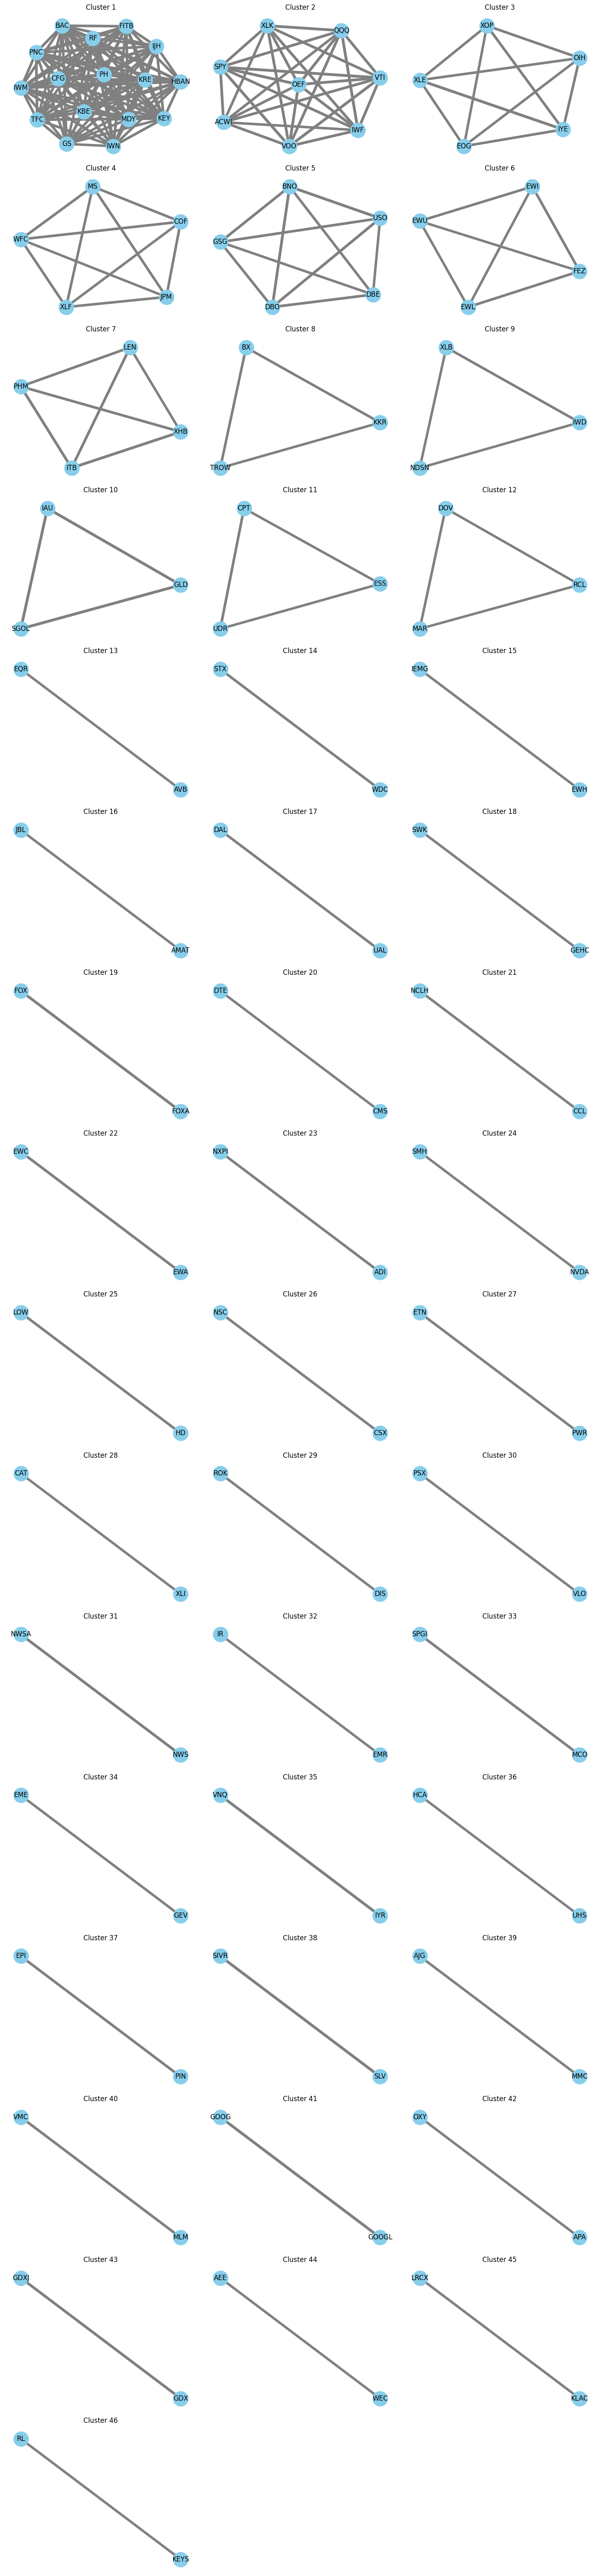

In [116]:
components = [G.subgraph(c).copy() for c in unique_clusters]

n = len(components)
cols = 3  # number of columns in grid
rows = -(-n // cols)  # ceiling division

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))

# If only one subplot
if n == 1:
    axes = [[axes]]
elif rows == 1:
    axes = [axes]

axes = [ax for row_axes in axes for ax in (row_axes if isinstance(row_axes, (list, np.ndarray)) else [row_axes])]

for i, component in enumerate(components):
    ax = axes[i]
    pos = nx.spring_layout(component, seed=42)

    # Draw nodes, edges, and labels
    nx.draw(component, pos, ax=ax, with_labels=True, node_color='skyblue', node_size=700,
            edge_color='gray', width=[component[u][v]['weight'] * 5 for u, v in component.edges()])
    
    ax.set_title(f"Cluster {i+1}")
    ax.axis('off')

# Turn off unused axes
for j in range(len(components), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [117]:
# RISK FREE RETURN BASED OF OFF US TREASSURY NOTE
# ANNUALIZED RETURN FOR NOTE IS 4.33%
RISK_FREE_RETURN =  (4.33/100)/12 # Divide for 12 months in a year

def calc_sharpe_ratio(stocks, all_security_data,cluster_num=None, verbose = False):
    """
    Create a function to calculate the Sharpe ratios of a list of stocks. 
    Save top security and more if thresholds are met.

    Input: list of stocks
    Output: df
    """
    sharpe_ratios = []
    
    for stock in stocks:
        temp = all_security_data.query('Symbol == @stock')
        
        pct_change_avg = temp.Monthly_Pct_Change.mean()
        dev_returns = temp.Monthly_Pct_Change.std()
        
        if dev_returns == 0:
            print(f"Standard deviation is zero for {stock}, skipping...")
            continue

        monthly_sharpe_ratio = (pct_change_avg - RISK_FREE_RETURN) / dev_returns
        
        if verbose:
            print(f"Sharpe Ratio (Monthly) for {stock}: {monthly_sharpe_ratio:.4f}")
            print(f"Sharpe Ratio (Annualized): {monthly_sharpe_ratio * np.sqrt(12):.4f}")
            print("-----------------------------------------------------------------------------------------")

        if monthly_sharpe_ratio*np.sqrt(12) >= 0.5:
            sharpe_ratios.append(
                (stock, monthly_sharpe_ratio, monthly_sharpe_ratio * np.sqrt(12))
            )
        if verbose:
            print()
    
    if not sharpe_ratios:
        if verbose:
            print("No good stocks")
        return

    sharpe_df = pd.DataFrame(sharpe_ratios, columns=["Symbol", "Monthly_Sharpe_Ratio", "Annualized_Sharpe_Ratio"])
    sharpe_df = sharpe_df.sort_values(by="Annualized_Sharpe_Ratio", ascending=False)

    sharpe_df["Group"] = f"Cluster: {cluster_num}"

    top_sharpe_df = sharpe_df.head(1)
    filtered_remainder = sharpe_df[1:].query('Annualized_Sharpe_Ratio >= 1.75') # This is for getting extra stocks from the larges second cluster

    if filtered_remainder.empty:
        return top_sharpe_df

    return pd.concat([top_sharpe_df, filtered_remainder])

# Initialize Portfolio df here with previously seen best performing stocks(just 1)
test = calc_sharpe_ratio(top_performers.Symbol.tolist()[:2], all_security_data, "Top").tail(1)

In [118]:
test

,Symbol,Monthly_Sharpe_Ratio,Annualized_Sharpe_Ratio,Group
1,PLTR,0.766688,2.655886,Cluster: Top


In [119]:
portfolio_df = pd.DataFrame() # Create empty dataframe with all securities

# Create Portfolio
for i, cluster in enumerate(unique_clusters, 1):
    print(f"Cluster {i}")
    temp = calc_sharpe_ratio(cluster, all_security_data, str(i))
    display(temp)

    portfolio_df = pd.concat([portfolio_df, temp])
    
    print()

Cluster 1


,Symbol,Monthly_Sharpe_Ratio,Annualized_Sharpe_Ratio,Group
2,GS,0.403183,1.396667,Cluster: 1



Cluster 2


,Symbol,Monthly_Sharpe_Ratio,Annualized_Sharpe_Ratio,Group
0,IWF,0.262938,0.910844,Cluster: 2



Cluster 3


None


Cluster 4


,Symbol,Monthly_Sharpe_Ratio,Annualized_Sharpe_Ratio,Group
2,JPM,0.427012,1.479213,Cluster: 4



Cluster 5


None


Cluster 6


,Symbol,Monthly_Sharpe_Ratio,Annualized_Sharpe_Ratio,Group
1,EWI,0.444161,1.538619,Cluster: 6



Cluster 7


None


Cluster 8


None


Cluster 9


None


Cluster 10


,Symbol,Monthly_Sharpe_Ratio,Annualized_Sharpe_Ratio,Group
2,SGOL,0.568182,1.968239,Cluster: 10
1,IAU,0.565930,1.960440,Cluster: 10
0,GLD,0.562440,1.948350,Cluster: 10



Cluster 11


None


Cluster 12


,Symbol,Monthly_Sharpe_Ratio,Annualized_Sharpe_Ratio,Group
0,RCL,0.491454,1.702447,Cluster: 12



Cluster 13


None


Cluster 14


,Symbol,Monthly_Sharpe_Ratio,Annualized_Sharpe_Ratio,Group
1,WDC,0.337677,1.169749,Cluster: 14



Cluster 15


,Symbol,Monthly_Sharpe_Ratio,Annualized_Sharpe_Ratio,Group
1,EWH,0.238981,0.827856,Cluster: 15



Cluster 16


,Symbol,Monthly_Sharpe_Ratio,Annualized_Sharpe_Ratio,Group
0,JBL,0.50954,1.765098,Cluster: 16



Cluster 17


,Symbol,Monthly_Sharpe_Ratio,Annualized_Sharpe_Ratio,Group
1,UAL,0.401376,1.390408,Cluster: 17



Cluster 18


None


Cluster 19


,Symbol,Monthly_Sharpe_Ratio,Annualized_Sharpe_Ratio,Group
0,FOXA,0.468825,1.624056,Cluster: 19



Cluster 20


,Symbol,Monthly_Sharpe_Ratio,Annualized_Sharpe_Ratio,Group
0,DTE,0.144886,0.501901,Cluster: 20



Cluster 21


,Symbol,Monthly_Sharpe_Ratio,Annualized_Sharpe_Ratio,Group
0,CCL,0.394455,1.366433,Cluster: 21



Cluster 22


,Symbol,Monthly_Sharpe_Ratio,Annualized_Sharpe_Ratio,Group
0,EWC,0.2988,1.035073,Cluster: 22



Cluster 23


None


Cluster 24


,Symbol,Monthly_Sharpe_Ratio,Annualized_Sharpe_Ratio,Group
0,NVDA,0.336693,1.166339,Cluster: 24



Cluster 25


None


Cluster 26


None


Cluster 27


,Symbol,Monthly_Sharpe_Ratio,Annualized_Sharpe_Ratio,Group
0,PWR,0.259213,0.897941,Cluster: 27



Cluster 28


,Symbol,Monthly_Sharpe_Ratio,Annualized_Sharpe_Ratio,Group
0,XLI,0.186659,0.646606,Cluster: 28



Cluster 29


,Symbol,Monthly_Sharpe_Ratio,Annualized_Sharpe_Ratio,Group
1,ROK,0.245449,0.850261,Cluster: 29



Cluster 30


None


Cluster 31


,Symbol,Monthly_Sharpe_Ratio,Annualized_Sharpe_Ratio,Group
0,NWS,0.25945,0.898762,Cluster: 31



Cluster 32


,Symbol,Monthly_Sharpe_Ratio,Annualized_Sharpe_Ratio,Group
0,EMR,0.21652,0.750048,Cluster: 32



Cluster 33


None


Cluster 34


,Symbol,Monthly_Sharpe_Ratio,Annualized_Sharpe_Ratio,Group
0,GEV,0.655448,2.27054,Cluster: 34



Cluster 35


None


Cluster 36


None


Cluster 37


None


Cluster 38


,Symbol,Monthly_Sharpe_Ratio,Annualized_Sharpe_Ratio,Group
0,SIVR,0.349209,1.209696,Cluster: 38



Cluster 39


None


Cluster 40


,Symbol,Monthly_Sharpe_Ratio,Annualized_Sharpe_Ratio,Group
0,VMC,0.19964,0.691574,Cluster: 40



Cluster 41


,Symbol,Monthly_Sharpe_Ratio,Annualized_Sharpe_Ratio,Group
0,GOOGL,0.303176,1.050231,Cluster: 41



Cluster 42


None


Cluster 43


,Symbol,Monthly_Sharpe_Ratio,Annualized_Sharpe_Ratio,Group
0,GDXJ,0.486857,1.686521,Cluster: 43



Cluster 44


,Symbol,Monthly_Sharpe_Ratio,Annualized_Sharpe_Ratio,Group
1,AEE,0.312255,1.081684,Cluster: 44



Cluster 45


,Symbol,Monthly_Sharpe_Ratio,Annualized_Sharpe_Ratio,Group
0,LRCX,0.244859,0.848216,Cluster: 45



Cluster 46


,Symbol,Monthly_Sharpe_Ratio,Annualized_Sharpe_Ratio,Group
0,RL,0.39078,1.353702,Cluster: 46


In [120]:
# Create budget
BUDGET = 10000

In [121]:
# Get close price
portfolio_df["Close"] = portfolio_df["Symbol"].apply(
    lambda symbol: float(all_security_data.query('Symbol == @symbol')['close'].iloc[-1])
)
# Get type of investment
portfolio_df["instrumentType"] = portfolio_df["Symbol"].apply(
    lambda symbol: str(all_security_data.query('Symbol == @symbol')['instrumentType'].iloc[0])
)
# Frac 
portfolio_df['frac_inv'] = portfolio_df["Monthly_Sharpe_Ratio"] / portfolio_df["Monthly_Sharpe_Ratio"].sum()
#number of shares
portfolio_df["n_shares"] = (BUDGET * portfolio_df['frac_inv']/portfolio_df['Close'])
#total amount to invest
portfolio_df["invt_amount"] = portfolio_df["n_shares"] * portfolio_df['Close']

#portfolio_df = portfolio_df.sort_values(by = 'Annualized_Sharpe_Ratio', ascending = False) # Sort
portfolio_df = portfolio_df.drop_duplicates(subset = "Symbol", ) # Drop some that were added twice(top 5 performers)

In [122]:
display(portfolio_df)
print(f"Number of Securities: {len(portfolio_df)}")
print(f"Sectors Invested in: {portfolio_df.Group.nunique()}")

,Symbol,Monthly_Sharpe_Ratio,Annualized_Sharpe_Ratio,Group,Close,instrumentType,frac_inv,n_shares,invt_amount
2,GS,0.403183,1.396667,Cluster: 1,735.744995,EQUITY,0.036766,0.499718,367.664692
0,IWF,0.262938,0.910844,Cluster: 2,451.880005,ETF,0.023977,0.530615,239.774506
2,JPM,0.427012,1.479213,Cluster: 4,292.440002,EQUITY,0.038939,1.331537,389.394628
1,EWI,0.444161,1.538619,Cluster: 6,50.509998,ETF,0.040503,8.018862,405.032717
2,SGOL,0.568182,1.968239,Cluster: 10,34.650101,ETF,0.051813,14.953143,518.127919
1,IAU,0.565930,1.960440,Cluster: 10,68.489998,ETF,0.051607,7.535040,516.074849
0,GLD,0.562440,1.948350,Cluster: 10,334.494995,ETF,0.051289,1.533333,512.892278
0,RCL,0.491454,1.702447,Cluster: 12,350.820007,EQUITY,0.044816,1.277463,448.159558
1,WDC,0.337677,1.169749,Cluster: 14,92.165001,EQUITY,0.030793,3.341072,307.929870
1,EWH,0.238981,0.827856,Cluster: 15,21.315001,ETF,0.021793,10.224179,217.928372


Number of Securities: 30
Sectors Invested in: 28


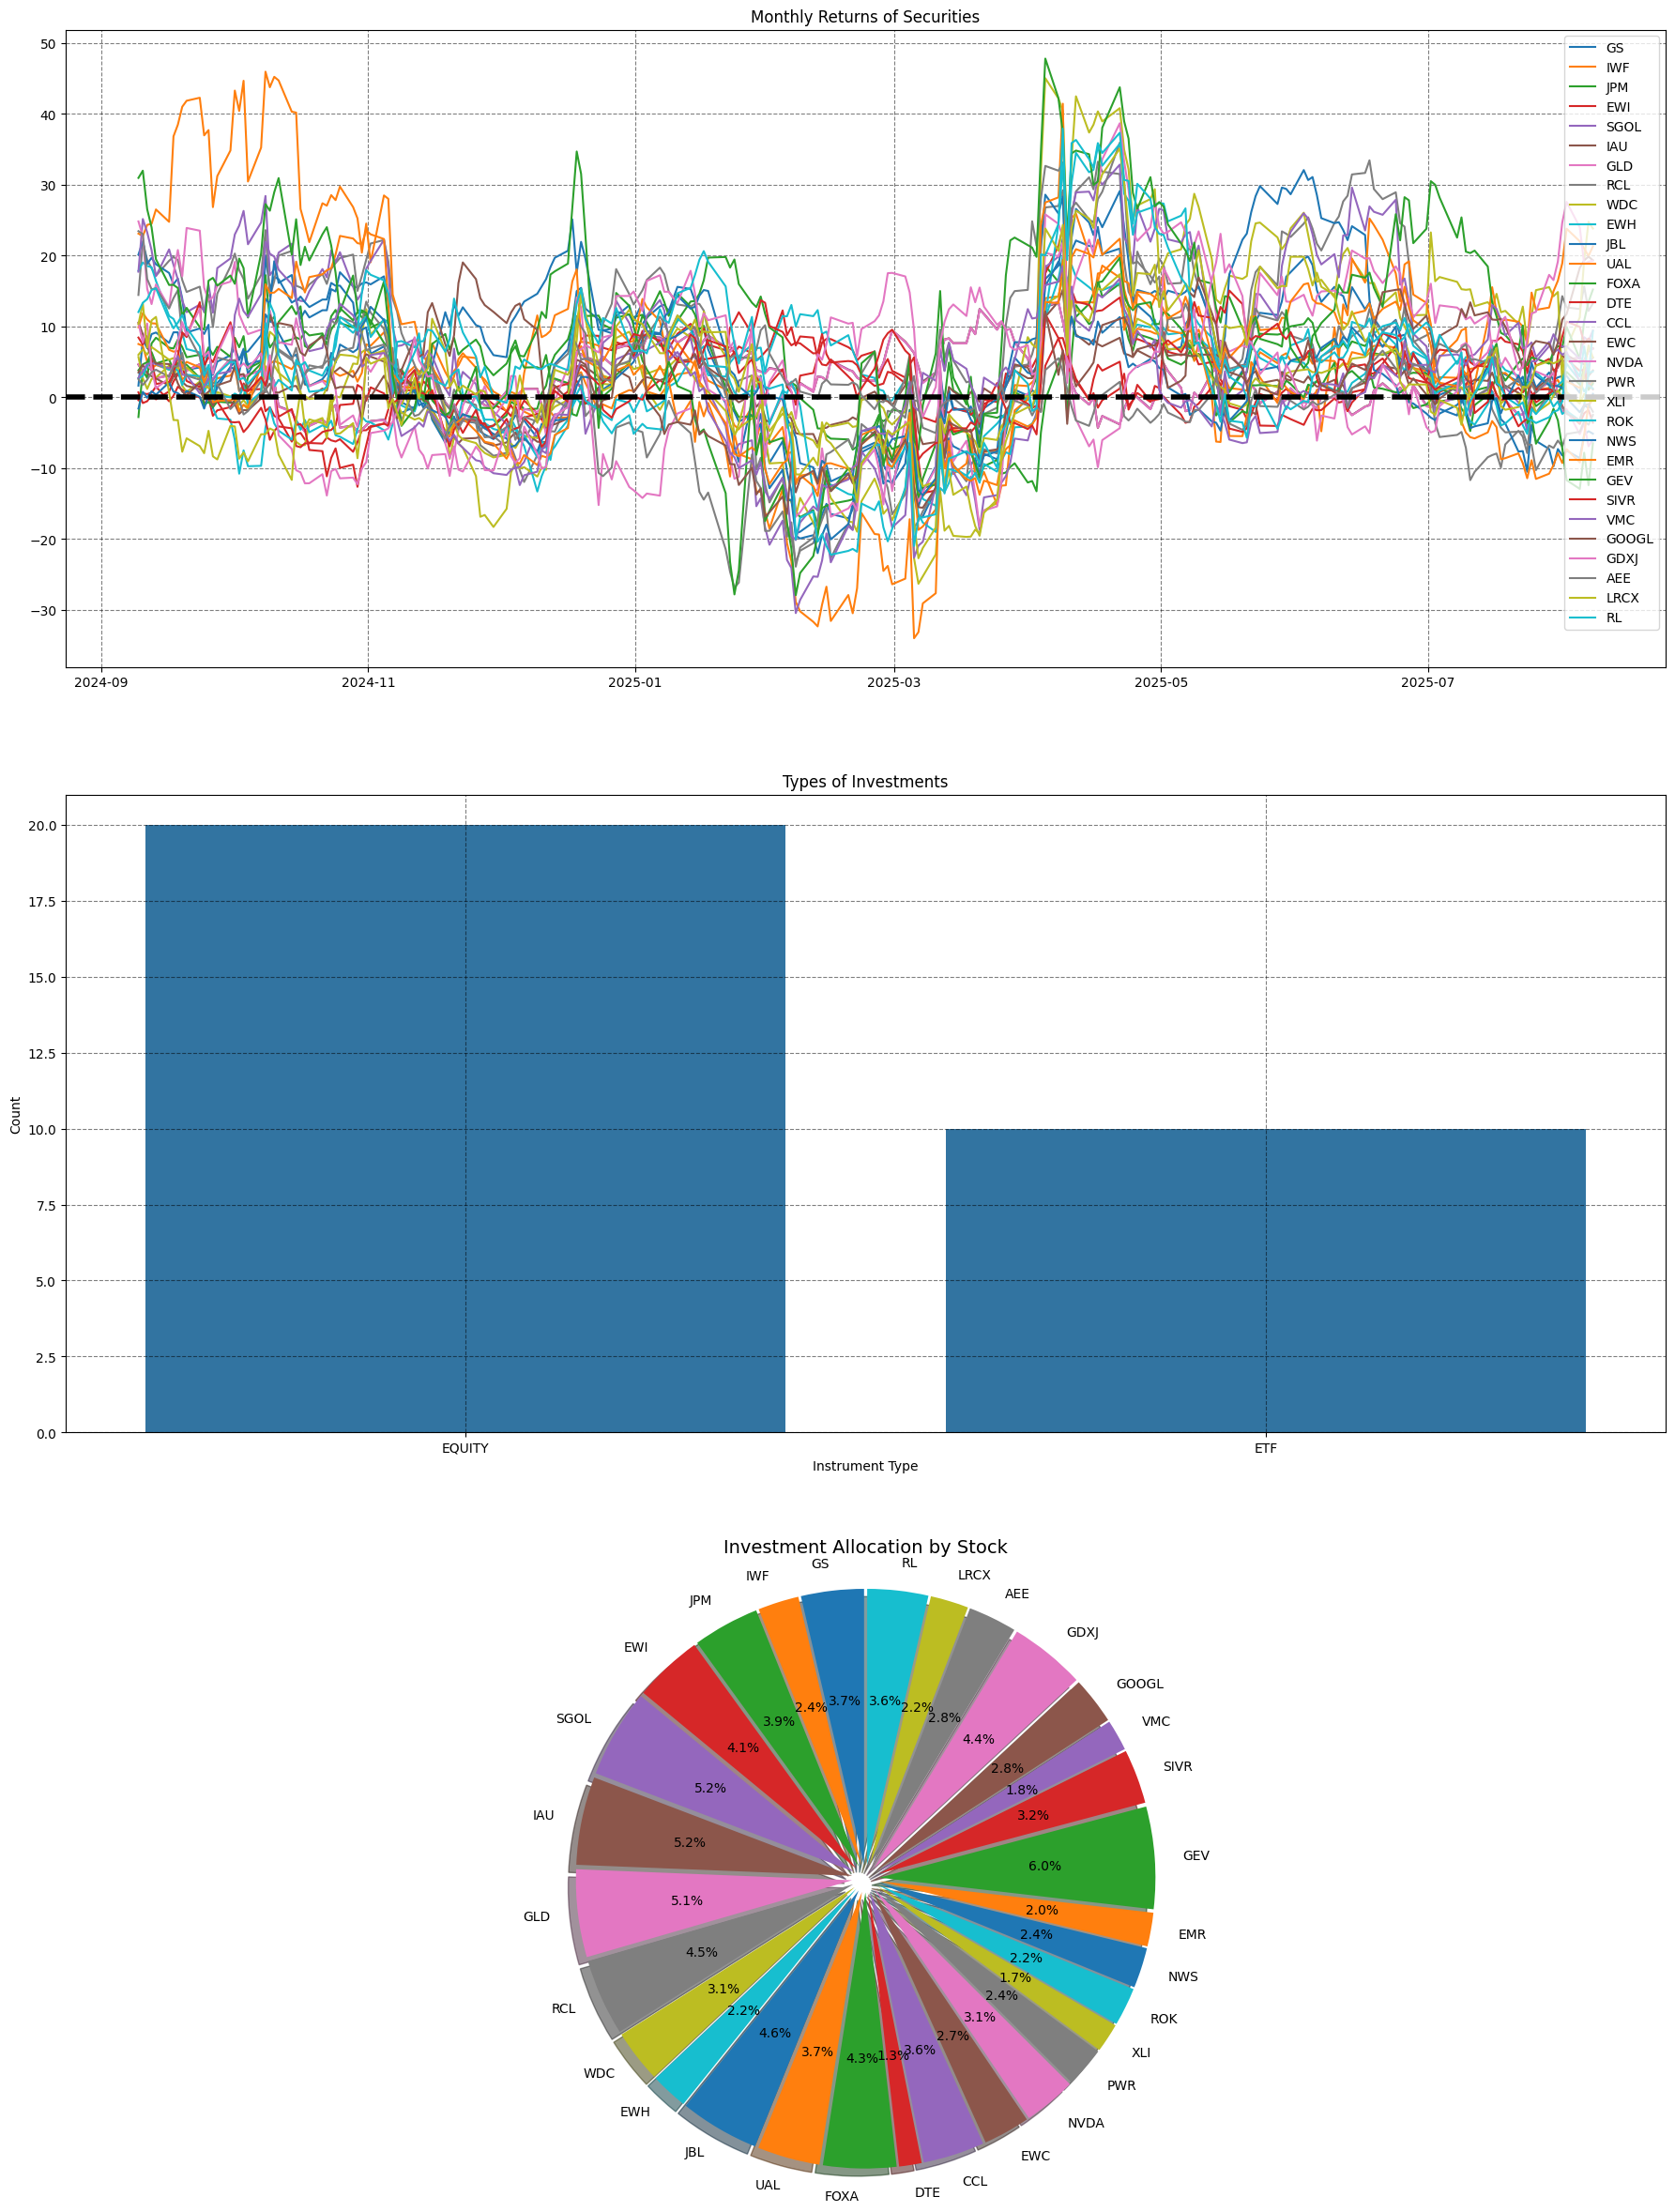

In [91]:
# Plot
fig, ax = plt.subplots(3, 1, figsize = (22, 30))

# Plot one
for sec in portfolio_df.Symbol:
    temp_df = all_security_data.query('Symbol == @sec')
    #temp_df.plot(x = temp.index, y = 'close', label = sec, ax=ax[0])
    ax[0].plot(temp_df.index, (temp_df['Monthly_Pct_Change'])*100, label = sec)
    
ax[0].legend()
ax[0].grid(linestyle = '--', alpha = 0.5, color = 'k')
ax[0].set_title("Monthly Returns of Securities")
ax[0].axhline(y = 0, color = 'k', linewidth = 4, linestyle = '--')

# Second Plot Etfs
sns.countplot(data=portfolio_df, x="instrumentType",ax=ax[1])
ax[1].set_xlabel("Instrument Type"); ax[1].set_ylabel("Count"); ax[1].set_title("Types of Investments")
ax[1].grid(linestyle = '--', alpha = 0.5, color = 'k')


# Third Plot
explode = [0.05] * len(portfolio_df)  # Slightly separate all slices

ax[2].pie(
    portfolio_df["invt_amount"],
    labels=portfolio_df["Symbol"],
    autopct='%1.1f%%',
    explode=explode,
    shadow=True,
    startangle=90,
    textprops={'fontsize': 10}
)

ax[2].set_title("Investment Allocation by Stock", fontsize=14)
ax[2].axis('equal')  
plt.show()

In [92]:
# Save df 
portfolio_df.to_csv("sept-07-portfolio.csv", index = False)

## We will now create an alternate portfolio choosing just the best stocks from thee 11 industries and 4 etfs

In [ ]:
# def sharpe_ratio()

In [93]:
#Sym --> industry
symb_to_industry = dict(zip(sp500_tickers_df["Symbol"], sp500_tickers_df["GICS Sector"]))

In [94]:
# Ticker --> ETF Type
etfs_to_type = dict(zip(etfs.Ticker, etfs.Type))

In [95]:
# Map the industry to each symbol
def map_industry(row):
    if row['instrumentType'] == 'EQUITY':
        return symb_to_industry.get(row['Symbol'], 'Unknown')
    elif row['instrumentType'] == 'ETF':
        return etfs_to_type.get(row['Symbol'], 'Unknown')
    else:
        return 'Unknown'

def sharpe_ratio(series):
    global RISK_FREE_RETURN
    """Groupby each ticker to get its monthly sharpe ratio"""
    msr = (series.mean() - RISK_FREE_RETURN) / series.std()
    return msr
    
all_security_data["Type"] = all_security_data.apply(map_industry, axis = 1)

In [96]:
all_security_data

,low,high,open,close,instrumentType,Symbol,Monthly_Pct_Change,Type
timestamp,,,,,,,,
2024-09-09 13:30:00,128.190002,130.979996,129.389999,128.460007,EQUITY,MMM,0.048498,Industrials
2024-09-10 13:30:00,128.460007,130.160004,128.850006,130.089996,EQUITY,MMM,0.037820,Industrials
2024-09-11 13:30:00,127.120003,130.380005,129.500000,130.229996,EQUITY,MMM,0.024802,Industrials
2024-09-12 13:30:00,130.100006,132.720001,130.300003,132.029999,EQUITY,MMM,0.020601,Industrials
2024-09-13 13:30:00,131.350006,133.369995,131.880005,133.179993,EQUITY,MMM,0.019372,Industrials
...,...,...,...,...,...,...,...,...
2025-08-29 13:30:00,56.930000,57.700001,56.930000,57.669998,ETF,EZA,NaN,country-etfs
2025-09-02 13:30:00,56.549999,57.320000,56.680000,57.250000,ETF,EZA,NaN,country-etfs
2025-09-03 13:30:00,57.439999,57.939999,57.689999,57.700001,ETF,EZA,NaN,country-etfs


In [97]:
sharpe_ratio_df = all_security_data.groupby(['Symbol', 'Type'])['Monthly_Pct_Change'].apply(sharpe_ratio).to_frame("Monthly_Sharpe_Ratio").reset_index()
sharpe_ratio_df["Annualized_Sharpe_Ration"] = sharpe_ratio_df["Monthly_Sharpe_Ratio"] * np.sqrt(12)

sharpe_ratio_df.sort_values(by = "Annualized_Sharpe_Ration", ascending = False)

,Symbol,Type,Monthly_Sharpe_Ratio,Annualized_Sharpe_Ration
258,HOOD,Financials,0.833694,2.888001
426,PLTR,Information Technology,0.766688,2.655886
128,DASH,Consumer Discretionary,0.676274,2.342681
232,GEV,Industrials,0.655448,2.270540
503,TPR,Consumer Discretionary,0.623849,2.161076
...,...,...,...,...
277,IFF,Materials,-0.726038,-2.515068
150,DOW,Materials,-0.784908,-2.719002
111,CPB,Consumer Staples,-0.811446,-2.810933
75,CAG,Consumer Staples,-0.926205,-3.208469


In [98]:
top_performers = sharpe_ratio_df.loc[
    sharpe_ratio_df.groupby('Type')['Monthly_Sharpe_Ratio'].idxmax()
]

In [99]:
# Here is our laternate investment account with 14 investments
top_performers["Close"] = top_performers["Symbol"].apply(
    lambda symbol: float(all_security_data.query('Symbol == @symbol')['close'].iloc[-1])
)
# Frac 
top_performers['frac_inv'] = top_performers["Monthly_Sharpe_Ratio"] / top_performers["Monthly_Sharpe_Ratio"].sum()
#number of shares
top_performers["n_shares"] = (BUDGET * top_performers['frac_inv']/top_performers['Close'])
#total amount to invest
top_performers["invt_amount"] = top_performers["n_shares"] * top_performers['Close']

In [100]:
top_performers

,Symbol,Type,Monthly_Sharpe_Ratio,Annualized_Sharpe_Ration,Close,frac_inv,n_shares,invt_amount
513,TTWO,Communication Services,0.561905,1.946496,248.115005,0.071303,2.873785,713.029263
128,DASH,Consumer Discretionary,0.676274,2.342681,249.429993,0.085816,3.440474,858.157368
147,DLTR,Consumer Staples,0.454273,1.573649,97.430000,0.057645,5.916555,576.449980
176,EQT,Energy,0.395832,1.371201,51.349998,0.050229,9.781699,502.290240
258,HOOD,Financials,0.833694,2.888001,115.550003,0.105792,9.155479,1057.915628
233,GILD,Health Care,0.439895,1.523840,115.680000,0.055820,4.825416,558.204140
232,GEV,Industrials,0.655448,2.270540,603.830017,0.083173,1.377426,831.730918
426,PLTR,Information Technology,0.766688,2.655886,157.220001,0.097289,6.188073,972.888878
123,CTVA,Materials,0.312470,1.082429,71.919998,0.039651,5.513198,396.509182
553,WELL,Real Estate,0.388212,1.344806,169.149994,0.049262,2.912337,492.621710


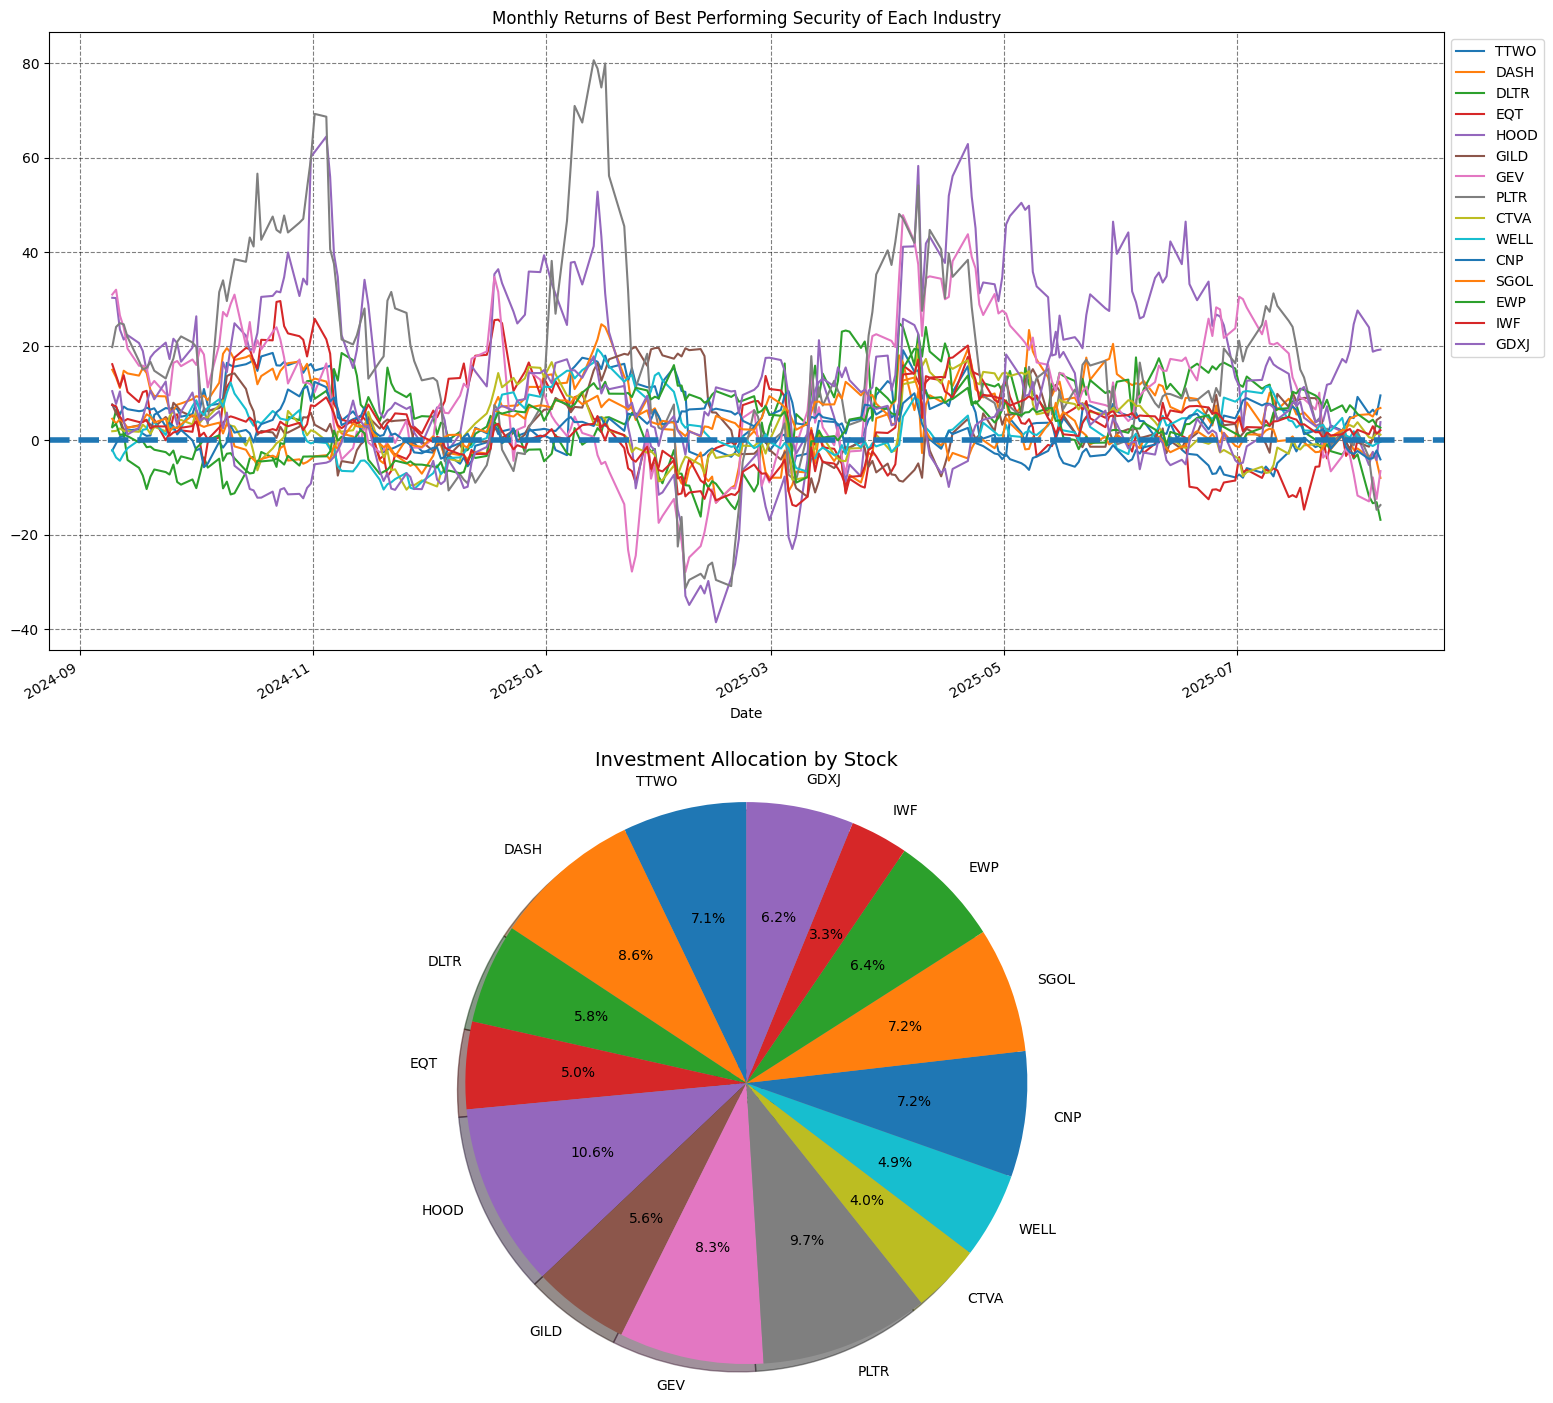

In [101]:
fig, ax = plt.subplots(2, 1,figsize=(18, 20))
for symb in top_performers.Symbol:
    temp = all_security_data.query('Symbol == @symb')
    temp["Monthly_Pct_Change"] = temp["Monthly_Pct_Change"]*100
    temp["Monthly_Pct_Change"].plot(ax=ax[0], label = symb)


ax[0].axhline(y=0, linewidth = 4, linestyle = '--')
ax[0].legend()
ax[0].grid(alpha = 0.5, color = 'k', linestyle='--')
ax[0].set_xlabel("Date")
ax[0].set_title("Monthly Returns of Best Performing Security of Each Industry")
leg = ax[0].get_legend()
leg.set_bbox_to_anchor((1, 1))


ax[1].pie(
    top_performers["invt_amount"],
    labels=top_performers["Symbol"],
    autopct='%1.1f%%',
    shadow=True,
    startangle=90,
    textprops={'fontsize': 10}
)

ax[1].set_title("Investment Allocation by Stock", fontsize=14)
ax[1].axis('equal')  

plt.show()

In [102]:
top_performers.to_csv("sector_portolio.csv", index = False)

# Thank you for viewing this notebook. In 1 month, I will create an update to see how our investments did
## PS: The control for this experiement will be the SP500 and HOOD(highest sharpe ratio)

In [103]:
all_security_data

,low,high,open,close,instrumentType,Symbol,Monthly_Pct_Change,Type
timestamp,,,,,,,,
2024-09-09 13:30:00,128.190002,130.979996,129.389999,128.460007,EQUITY,MMM,0.048498,Industrials
2024-09-10 13:30:00,128.460007,130.160004,128.850006,130.089996,EQUITY,MMM,0.037820,Industrials
2024-09-11 13:30:00,127.120003,130.380005,129.500000,130.229996,EQUITY,MMM,0.024802,Industrials
2024-09-12 13:30:00,130.100006,132.720001,130.300003,132.029999,EQUITY,MMM,0.020601,Industrials
2024-09-13 13:30:00,131.350006,133.369995,131.880005,133.179993,EQUITY,MMM,0.019372,Industrials
...,...,...,...,...,...,...,...,...
2025-08-29 13:30:00,56.930000,57.700001,56.930000,57.669998,ETF,EZA,NaN,country-etfs
2025-09-02 13:30:00,56.549999,57.320000,56.680000,57.250000,ETF,EZA,NaN,country-etfs
2025-09-03 13:30:00,57.439999,57.939999,57.689999,57.700001,ETF,EZA,NaN,country-etfs
